In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from plotly import tools
from chart_studio import plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, pytz

In [14]:
def dateparse (time_in_secs): 
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))
data = pd.read_csv('Data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv', parse_dates=[0], date_parser=dateparse) 

In [15]:
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
data = data.set_index('Timestamp')
data = data[['Weighted_Price']]
data['Weighted_Price'].fillna(method='ffill', inplace=True)

In [16]:
#Splitting data for train and test 

split_date = '01-Jan-2021'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

## LSTM

In [17]:
#preprocess data

training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

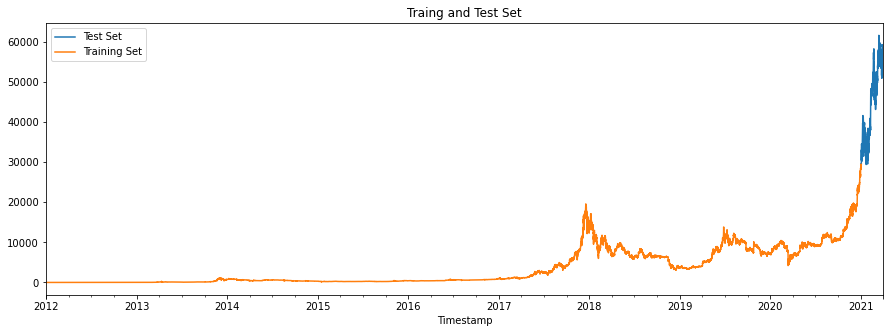

In [19]:
_ = data_test \
    .rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='Traing and Test Set', style='')

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
1579/1579 - 2s - loss: 0.0170
Epoch 2/100
1579/1579 - 2s - loss: 0.0034
Epoch 3/100
1579/1579 - 2s - loss: 0.0020
Epoch 4/100
1579/1579 - 2s - loss: 0.0013
Epoch 5/100
1579/1579 - 2s - loss: 9.6033e-04
Epoch 6/100
1579/1579 - 2s - loss: 7.2683e-04
Epoch 7/100
1579/1579 - 2s - loss: 5.7615e-04
Epoch 8/100
1579/1579 - 2s - loss: 4.6631e-04
Epoch 9/100
1579/1579 - 2s - loss: 4.0332e-04
Epoch 10/100
1579/1579 - 2s - loss: 3.4799e-04
Epoch 11/100
1579/1579 - 2s - loss: 3.1089e-04
Epoch 12/100
1579/1579 - 2s - loss: 2.8034e-04
Epoch 13/100
1579/1579 - 2s - loss: 2.6159e-04
Epoch 14/100
1579/1579 - 2s - loss: 2.4508e-04
Epoch 15/100
1579/1579 - 2s - loss: 2.3295e-04
Epoch 16/100
1579/1579 - 2s - loss: 2.2753e-04
Epoch 17/100
1579/1579 - 2s - loss: 2.1361e-04
Epoch 18/100
1579/1579 - 2s - loss: 2.1467e-04
Epoch 19/100
1579/1579 - 2s - loss: 2.0569e-04
Epoch 20/100
1579/1579 - 2s - loss: 2.0356e-04
Epoch 21/100
1579/1579 - 2s - loss: 2.0093e-04
Epoch 22/100
1579/1579 - 2s - loss: 1.

In [22]:
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

In [31]:
data_test['LSTM_Price_Prediction'] = predicted_BTC_price

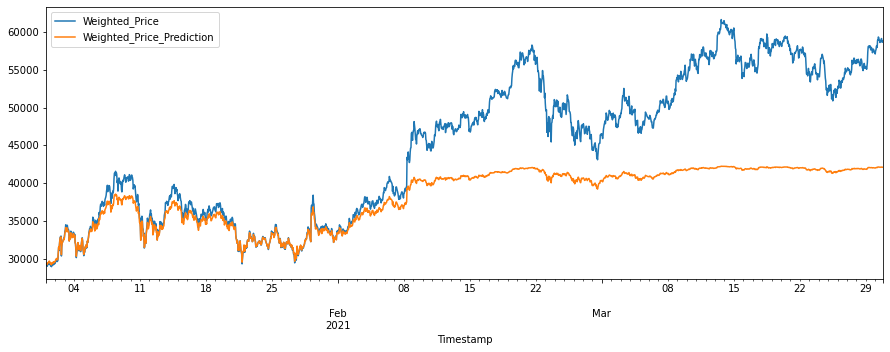

In [24]:
_ = data_test[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])
mae = mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])
print(mse,mae)

78328977.7075728 6599.021622038578


## XgBoost

In [27]:
#Create features for the model

def create_features(df, label=None):
    
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X


In [28]:
X_train, y_train = create_features(data_train, label='Weighted_Price')
X_test, y_test = create_features(data_test, label='Weighted_Price')

In [29]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
model =  xgb.XGBRegressor(objective ='reg:linear',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

[18:23:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [32]:
data_test['XGB_Price_Prediction'] = model.predict(X_test)

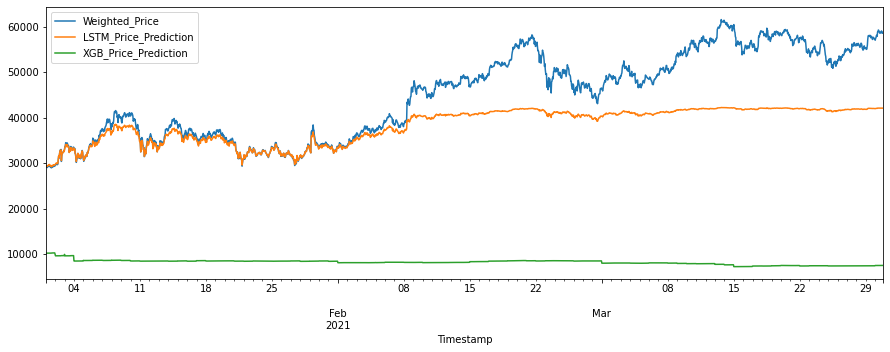

In [33]:
_ = data_test[['Weighted_Price','LSTM_Price_Prediction','XGB_Price_Prediction']].plot(figsize=(15, 5))